In [10]:
import torch, torchvision
transform = torchvision.transforms.Compose(
[torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)

Files already downloaded and verified


In [0]:
import random #shuffle the whole set and split it into train set and valid set
sids = list(range(50000))
random.shuffle(sids)
train_sids = sids[:45000]
valid_sids = sids[45000:]

In [0]:
all_data = [] #extract data and labels from dataset
all_labels = []
for i in range(len(trainset)):
  all_data.append(trainset[i][0].numpy().flatten())
  all_labels.append(trainset[i][1])


In [0]:
print ('haahh')

In [0]:
all_data = np.array(all_data) 
#obtain train set and valid set according to indexed ids
all_labels = np.array(all_labels)
train_data = all_data[train_sids]
train_labels = all_labels[train_sids]
valid_data = all_data[valid_sids]
valid_labels = all_labels[valid_sids]


In [0]:
import time
import numpy as np
class NeuralNetwork:
    def __init__(self, layer_dimensions):
        self.n_layers = len(layer_dimensions)
        self.weights = []
        self.bias = []
        self.num_class = 10
        self.trained_weights = []
        self.trained_bias = []
        for i in range(self.n_layers - 1): #initialization
            self.weights.append(np.random.uniform(-0.01, 0.01, \
                           (layer_dimensions[i], layer_dimensions[i+1])))
            self.bias.append(np.zeros(layer_dimensions[i+1]))


    def affineForward(self, A, W, b):
        return np.dot(A, W) + b 
    def activationForward(self, A):
        A[A<0] = 0.0
        return A
    def forwardPropagation(self, X, dropout):
        self.A = []
        self.Z = []
        if dropout: #apply dropout on the input layer
            X *= 1.0 / 0.7 * np.random.binomial(1, 0.7, np.shape(X))
        for i in range(self.n_layers - 1):
            self.A.append(X)
            X = self.affineForward(X, self.weights[i], self.bias[i])
            self.Z.append(X)
            if i < self.n_layers - 1 - 1: 
                #the last layer doesn't have activations
                X = self.activationForward(X)
                if dropout and i==0: #apply dropout on the first layer
                    X *= 1.0 / 0.7 * np.random.binomial(1, 0.7, np.shape(X))
        
        return X
    def softmax(self, A):
        A = A - np.max(A, 1, keepdims=True) 
        #subtract maximum value to maintain numerical stability

        return np.exp(A) / np.sum(np.exp(A), 1, keepdims=True)
    def costFunction(self, AL, labels):
        probs = self.softmax(AL)
        loss = 0.0
        for i in range(len(labels)):
            loss += - np.log(probs[i][labels[i]]) #cross entropy loss
        return probs, loss / len(labels)
    def affineBackward(self, dA_prev, cache):
        pass
    def activationBackward(self, dA, cache):
        pass
    def backPropagation(self, probs, labels): 
        #probs are matrix of predicted probability distribution
        #labels are true labels
        gradients_w = []                      
        gradients_b = []

        delta_last = np.zeros((len(labels), self.num_class)) 
        for i in range(len(labels)): 
            #calculate the last layer (softmax layer) error signal (delta)
            for j in range(self.num_class):
                if j == labels[i]: #-1/p * derivation of softmax
                    delta_last[i][j] = - 1.0 / probs[i][labels[i]] \
                    * probs[i][j] * (1 - probs[i][j])
                else: # -1/p * derivation of softmax
                    delta_last[i][j] = 1.0 / probs[i][labels[i]] \
                    * probs[i][j] * probs[i][labels[i]]

        for i in range(self.n_layers - 2, -1, -1): 
            #calculate the gradient of w, b and the error signal
            gradient_w = 1.0 / len(labels) * np.dot(self.A[-1].T, delta_last) 
            #dJ/dw_l = dot(A_l.T, delta_l+1)
            gradient_b = np.average(delta_last, 0) 
            #dJ/db_l = delta_l+1

            gradients_w.append(gradient_w)
            gradients_b.append(gradient_b) 
            if i >= 1: #delta_l = dot(delta_l+1, w_l+1.T) * f'(z_l+1). 
                #delta is needed for layers except input layer
                delta_last = np.dot(delta_last, np.transpose(self.weights[i])) \
                * self.reluGradient(self.Z[i-1])
            self.A.pop()
        return gradients_w, gradients_b

        

    def reluGradient(self, Z):
        Z[Z>0] = 1.0
        Z[Z<0] = 0
        return Z

    def updateParameters(self, gradients, alpha):
        gradients_w, gradients_b = gradients
        for i in range(self.n_layers - 1):#gradient descent
            self.weights[i] -= alpha * gradients_w[-(i+1)]
            self.bias[i] -= alpha * gradients_b[-(i+1)]

    def runEpoch(self, data, labels, batch_size, if_train, lr): 
        #run one traversal on dataset
        tmp_data = data.copy()
        tmp_golds = labels.copy()

        if if_train: #shuffle training data before each run
            sids = list(range(len(data)))
            random.shuffle(sids)
            for index in range(len(sids)):
                tmp_data[index] = data[sids[index]]
                tmp_golds[index] = labels[sids[index]]
		
        tmp_data = tmp_data[:len(tmp_data)-len(tmp_data) % batch_size] 
        #split data and labels into mini batches
        iter_size = int(len(tmp_data) / batch_size)  
        # number of iteration needed
        tmp_data = tmp_data.reshape((iter_size, batch_size, -1))

        tmp_golds = tmp_golds[:len(tmp_golds)-len(tmp_golds) % batch_size]
        tmp_golds = tmp_golds.reshape((iter_size, batch_size))
        total_loss = 0.0
        num_corrects = 0
        for j in range(iter_size):

            if if_train: #use dropout on training set
            	AL = self.forwardPropagation(tmp_data[j], True)
            else:
            	AL = self.forwardPropagation(tmp_data[j], False)
            probs, loss = self.costFunction(AL, tmp_golds[j])
            num_corrects += np.sum(np.argmax(probs, 1) == tmp_golds[j])
            total_loss += loss

            if if_train: #do back propagation when training
                gradients_w, gradients_b = self.backPropagation(probs, 
                                                                tmp_golds[j])
                self.updateParameters([gradients_w, gradients_b], lr)
        acc = float(num_corrects) / (iter_size * batch_size)
        return total_loss / iter_size, acc
        #return loss and accuracy

    def train(self, train_data, valid_data, train_labels, valid_labels, 
              max_epoch, epochs, alpha, batch_size):
        lr = alpha
        best_valid = float('-inf')
        for i in range(epochs):
            epoch_start_time = time.time()
            train_loss, train_acc = self.runEpoch(train_data, train_labels, 
                                                  batch_size, True, lr)
            valid_loss, valid_acc = self.runEpoch(valid_data, valid_labels, 
                                                  batch_size, False, lr)
            if valid_acc > best_valid:
                best_valid = valid_acc
                self.trained_weights = \
                [weight.copy() for weight in self.weights] 
                #store the best weights and bias
                self.trained_bias = [bias.copy() for bias in self.bias]
            else:
                if i >= max_epoch: #after max_epoch, reduce the learning rate
                    lr *= 0.8
                        
            print('| epoch {:2d}| lr: {:.5f} | time: {:4.2f}s | \
train_acc {:5.4f} |\n| train_loss {:5.5f} | valid_acc {:5.4f} | best_acc {:.4f}\
 |'.format(i, lr, (time.time() - epoch_start_time), train_acc, \
                  train_loss, valid_acc, best_valid))

    def predict(self, X_new, batch_size):
        self.weights = [weight.copy() for weight in self.trained_weights]
        self.bias = [bias.copy() for bias in self.trained_bias]
        #reload the best trained weights and bias from class attrributes
        tmp_data = X_new.copy()

        tmp_data = tmp_data[:len(tmp_data)-len(tmp_data) % batch_size] 
        #split data and labels into mini batches
        iter_size = int(len(tmp_data) / batch_size)  
        # number of iteration needed
        tmp_data = tmp_data.reshape((iter_size, batch_size, -1))
        predicts = []
        for j in range(iter_size):
            AL = self.forwardPropagation(tmp_data[j], False)
            probs = self.softmax(AL)
            predicts.extend(np.argmax(probs, 1)) #get the predicted labels
        return predicts
            

In [0]:
model = NeuralNetwork([3072, 1024, 512, 256, 10])
model.train(train_data, valid_data, train_labels, valid_labels, 
            max_epoch=20, epochs=55, alpha=0.5, batch_size=500)

| epoch  0| lr: 0.50000 | time: 45.19s | train_acc 0.1036 |
| train_loss 2.30267 | valid_acc 0.1220 | best_acc 0.1220 |
| epoch  1| lr: 0.50000 | time: 45.88s | train_acc 0.1610 |
| train_loss 2.19696 | valid_acc 0.1980 | best_acc 0.1980 |
| epoch  2| lr: 0.50000 | time: 46.17s | train_acc 0.2329 |
| train_loss 1.97821 | valid_acc 0.2786 | best_acc 0.2786 |
| epoch  3| lr: 0.50000 | time: 45.45s | train_acc 0.2938 |
| train_loss 1.86607 | valid_acc 0.3428 | best_acc 0.3428 |
| epoch  4| lr: 0.50000 | time: 45.18s | train_acc 0.3527 |
| train_loss 1.76727 | valid_acc 0.3892 | best_acc 0.3892 |
| epoch  5| lr: 0.50000 | time: 45.79s | train_acc 0.3958 |
| train_loss 1.66490 | valid_acc 0.4072 | best_acc 0.4072 |
| epoch  6| lr: 0.50000 | time: 45.21s | train_acc 0.4249 |
| train_loss 1.59180 | valid_acc 0.4488 | best_acc 0.4488 |
| epoch  7| lr: 0.50000 | time: 45.80s | train_acc 0.4470 |
| train_loss 1.53465 | valid_acc 0.4654 | best_acc 0.4654 |
| epoch  8| lr: 0.50000 | time: 45.59s |

In [0]:
test_data = []
test_labels = []
for i in range(len(testset)): #extract testdata and testlabel
  test_data.append(testset[i][0].numpy().flatten())
  test_labels.append(testset[i][1])

test_data = np.array(test_data)
test_labels = np.array(test_labels)


In [119]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { height:50% !important; }</style>"))

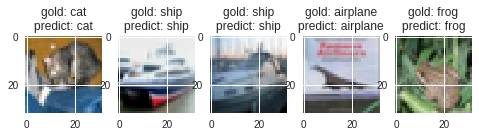

In [113]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
maps = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples = model.predict(test_data, 500)[:10]
for i in range(5):
    ax = plt.subplot(151+i)
    ax.set_title('gold: ' + maps[testset[i][1]] + '\n' + 'predict: ' + maps[samples[i]])
    imshow(testset[i][0])